# Package

In [121]:
# Import necessary packages
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import math
import csv
from pathlib import Path
import os, json
from datetime import datetime
import matplotlib.pyplot as plt
import time

# Noted

In [122]:
material = "CH467160"
way = "uesed_for_PFC_test1"
noted = "使用一般FNＮ訓練、只訓練1000筆"
test_mode = "test"  # test_PFC_core2

#  Model structures

In [123]:
# Define model structures and functions
class Net(nn.Module):

    def __init__(self,
                 load_pretrained: bool = False,
                 pretrained_model_path: str = "None"):
        super(Net, self).__init__()
        # Define a fully connected layers model with three inputs (frequency, flux density, duty ratio) and one output (power loss).
        self.layers = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        if load_pretrained and pretrained_model_path is not None:
            self.load_pretrained_model(pretrained_model_path)

    def forward(self, x):
        return self.layers(x)

    def load_pretrained_model(self, path):
        # 讀取並設置預訓練模型的權重
        pretrained_dict = torch.load(path)
        # 獲取當前模型的狀態字典
        model_dict = self.state_dict()
        # 更新當前模型的狀態字典中的權重
        model_dict.update(pretrained_dict)
        # 更新模型字典以匹配預訓練模型的字典
        self.load_state_dict(model_dict)
        print('Model is load')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load Dataset

In [124]:
def get_dataset(material, folder, base_path="./Data/"):

    root = f"{base_path}{material}/{folder}"
    B = read_csv(f"{root}/Bmax.csv")
    Freq = read_csv(f"{root}/Frequency.csv")
    Duty_P = read_csv(f"{root}/Duty_P.csv")
    Duty_N = read_csv(f"{root}/Duty_N.csv")
    Temp = read_csv(f"{root}/Temperature.csv")
    Turns = read_csv(f"{root}/Turns.csv")
    Dc = read_csv(f"{root}/Hdc.csv")
    Power = read_csv(f"{root}/Volumetric_Loss.csv")

    tensors = [B, Freq, Duty_P, Duty_N, Temp, Turns, Dc, Power]
    (B, Freq, Duty_P, Duty_N, Temp, Turns, Dc, Power) = [
        torch.as_tensor(a, dtype=torch.float32).view(-1, 1) for a in tensors
    ]

    eps_log = 1e-12  # 防 0 或負值
    B = torch.log10(torch.clamp(B, min=eps_log))
    Freq = torch.log10(torch.clamp(Freq, min=eps_log))
    Power = torch.log10(torch.clamp(Power, min=eps_log))  # ← 這也是 y label

    # ---------- 取得或建立 norm_stats ----------
    stats_path = f"{base_path}{material}/norm_stats.json"
    eps = 1e-8
    if "train" in folder.lower():  # ── train ──
        norm_stats = {
            "B": {
                "m": B.mean(),
                "s": B.std() + eps
            },
            "Freq": {
                "m": Freq.mean(),
                "s": Freq.std() + eps
            },
            "Temp": {
                "m": Temp.mean(),
                "s": Temp.std() + eps
            },
            "Turns": {
                "m": Turns.mean(),
                "s": Turns.std() + eps
            },
            "Dc": {
                "m": Dc.mean(),
                "s": Dc.std() + eps
            },
            "Duty_P": {
                "m": Duty_P.mean(),
                "s": Duty_P.std() + eps
            },
            "Duty_N": {
                "m": Duty_N.mean(),
                "s": Duty_N.std() + eps
            },
        }
        # 存成純 float（json 不支援 tensor）
        js = {
            k: {
                "m": v["m"].item(),
                "s": v["s"].item()
            }
            for k, v in norm_stats.items()
        }
        with open(stats_path, "w") as f:
            json.dump(js, f, indent=2)
        print(f"✅ 產生 norm_stats.json → {stats_path}")

    else:  # ── test ──
        if not os.path.exists(stats_path):
            raise FileNotFoundError("❌ 找不到 norm_stats.json，請先跑一次 train")
        with open(stats_path, "r") as f:
            js = json.load(f)
        # 轉回 tensor
        norm_stats = {
            k: {
                "m": torch.tensor(v["m"]),
                "s": torch.tensor(v["s"])
            }
            for k, v in js.items()
        }
        print(f"✅ 使用 train 階段的 norm_stats.json")

    # ---------- z-score 正規化 ----------
    def z(x, key):
        return (x - norm_stats[key]["m"]) / norm_stats[key]["s"]

    B, Freq = z(B, "B"), z(Freq, "Freq")
    Duty_P = z(Duty_P, "Duty_P")
    Duty_N = z(Duty_N, "Duty_N")
    Temp, Dc = z(Temp, "Temp"), z(Dc, "Dc")
    Turns = z(Turns, "Turns")

    features = torch.cat((B, Freq, Duty_P, Duty_N, Temp, Dc, Turns),
                         dim=1)  # (N,7)
    target = Power.float()  # (N,1)

    for idx, name in enumerate(
        ["B", "Freq", "Duty_P", "Duty_N", "Temp", "Dc", "Turns"]):
        col = features[:, idx]
        print(
            f"{name:6}  mean={col.mean():.2f}  std={col.std():.2f}  max={col.max():.2f}"
        )

    return torch.utils.data.TensorDataset(features, target)


def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='', encoding='utf-8-sig') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            values = [float(value) for value in row]
            data.append(values)
    return np.array(data)

# Logger

In [125]:
class SimpleLogger:

    def __init__(self, result_dir, exp_name, config):
        self.result_dir = result_dir
        os.makedirs(self.result_dir, exist_ok=True)
        with open(os.path.join(self.result_dir, "config.json"), "w") as f:
            json.dump(config, f, indent=2, ensure_ascii=False)
        self.metrics = {}

    def log_metrics(self, **kwargs):
        # 將所有要紀錄的值放進字典
        self.metrics.update(kwargs)

    def save(self):
        # 儲存 metrics.json
        with open(os.path.join(self.result_dir, "metrics.json"), "w") as f:
            json.dump(self.metrics, f, indent=2, ensure_ascii=False)

# Training and Testing the Model

In [126]:
def main():
    # === 1. 設定隨機種子 & 超參數 ===
    # Reproducibility
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hyperparameters
    NUM_EPOCH = 925
    BATCH_SIZE = 256
    DECAY_EPOCH = 200
    DECAY_RATIO = 0.5
    LR_INI = 0.005
    best_loss = math.inf
    early_stop_count = 0
    early_stop = 100
    # Select GPU as default device
    device = torch.device("cuda")

    # === 2. 準備資料與模型 ===
    # Load dataset
    dataset_train = get_dataset(material, "train")
    train_size = int(0.8 * len(dataset_train))
    valid_size = len(dataset_train) - train_size
    train_dataset, valid_dataset = torch.utils.data.random_split(
        dataset_train, [train_size, valid_size])

    dataset_test = get_dataset(material, test_mode)
    test_dataset = dataset_test

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(valid_dataset)}")
    print(f"Test dataset size: {len(dataset_test)}")

    kwargs = {
        'num_workers': 0,
        'pin_memory': True,
        'pin_memory_device': "cuda"
    }

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              **kwargs)

    # Setup network
    # net = Net().double().to(device)
    net = Net().to(device)

    # Log the number of parameters
    print("Number of parameters: ", count_parameters(net))

    # Setup optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=LR_INI)

    # === 3. 建立 Logger 並儲存超參數 ===
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    result_dir = f"./results/{material}_{timestamp}"
    config = {
        "NUM_EPOCH": NUM_EPOCH,
        "BATCH_SIZE": BATCH_SIZE,
        "LR_INI": LR_INI,
        "DECAY_EPOCH": DECAY_EPOCH,
        "DECAY_RATIO": DECAY_RATIO,
        "EARLY_STOP": early_stop,
    }
    logger = SimpleLogger(result_dir, exp_name=material, config=config)
    output_sd_path = os.path.join(result_dir, "best_model.sd")

    # === 4. 開始計時 ===
    t_start = time.perf_counter()

    # === 5. 訓練迴圈 ===

    print("=== Start Train  ===")
    print(r"""
    (\_/)
    ( •_•)
    / > 我想畢業QQQQQQQQQQQQ
    """)
    # Train the network
    best_loss = math.inf
    early_stop_count = 0
    epoch_times = []

    for epoch_i in range(NUM_EPOCH):

        # Train for one epoch
        t0 = time.perf_counter()
        epoch_train_loss = 0
        net.train()
        optimizer.param_groups[0]['lr'] = LR_INI * (DECAY_RATIO**(
            0 + epoch_i // DECAY_EPOCH))

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Compute Validation Loss
        with torch.no_grad():
            epoch_valid_loss = 0
            for inputs, labels in valid_loader:
                outputs = net(inputs.to(device))
                loss = criterion(outputs, labels.to(device))

                epoch_valid_loss += loss.item()

        if (epoch_i + 1) % 5 == 0:
            print(f"Epoch {epoch_i+1:2d} "
                  f"Train {epoch_train_loss / len(train_dataset) * 1e5:.5f} "
                  f"Valid {epoch_valid_loss / len(valid_dataset) * 1e5:.5f}")

        # Early stop
        epoch_valid_loss = epoch_valid_loss / len(valid_dataset) * 1e5
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            torch.save(net.state_dict(), output_sd_path)
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1
            print(f"Early stop count: {early_stop_count} / {early_stop}")

        if early_stop_count >= early_stop:
            print('Model is not improving, so we halt the training session.')
            break

        te = time.perf_counter() - t0
        epoch_times.append(te)
        print(f"---")
        print(f"Epoch {epoch_i+1:2d} finished in {te:.2f} seconds")

    # === 6. 訓練結束，計算總時間 ===
    elapsed_sec = time.perf_counter() - t_start
    print("Training finished! Model is saved!")

    # === 7. 載入最佳模型並做最終測試 ===
    # Test the model
    print("=== Start Test ===")
    net.load_state_dict(torch.load(output_sd_path))
    print("Best model is load to test")
    net.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            preds = net(inputs.to(device))
            all_preds.append(preds.cpu())
            all_labels.append(labels)

    y_pred = torch.cat(all_preds, dim=0)  # shape = (N, 1)
    y_meas = torch.cat(all_labels, dim=0)  # shape = (N, 1)

    yy_pred = 10**(y_pred.numpy())
    yy_meas = 10**(y_meas.numpy())

    pred_csv = os.path.join(result_dir, "pred.csv")
    meas_csv = os.path.join(result_dir, "meas.csv")

    np.savetxt(pred_csv, yy_pred, delimiter=",", comments="")
    np.savetxt(meas_csv, yy_meas, delimiter=",", comments="")
    print(f"✅  已輸出 {pred_csv} 與 {meas_csv}")

    # ========= 相對誤差計算 =========
    Error_re = np.abs(yy_pred - yy_meas) / np.abs(yy_meas) * 100  # [%]
    avg_err = np.mean(Error_re)
    pct95 = np.percentile(Error_re, 95)
    max_err = np.max(Error_re)

    print(
        f"Test Loss : {F.mse_loss(y_meas, y_pred).item() * 1e5 / len(test_dataset):.5f}"
    )
    print(f"AVG Error               : {avg_err:.6f} %")
    print(f"95-Percentile Error     : {pct95:.6f} %")
    print(f"MAX Error               : {max_err:.6f} %")

    # ========= Logger 紀錄 =========
    logger.log_metrics(test_loss=float(
        F.mse_loss(y_meas, y_pred).item() * 1e5 / len(test_dataset)),
                       avg_error=float(avg_err),
                       error_95pct=float(pct95),
                       error_max=float(max_err),
                       training_secs=elapsed_sec)
    logger.save()  # 會在 result_dir 產生 metrics.json

    # ========= Relative Error 直方圖 =========
    plt.figure(figsize=(10, 6))
    plt.hist(Error_re, bins=100, density=True, alpha=0.9)

    # 虛線 + 標籤
    plt.axvline(avg_err, linestyle='--', linewidth=1.5)
    plt.text(avg_err + 0.5,
             plt.ylim()[1] * 0.9,
             f"Avg = {avg_err:.2f}%",
             fontsize=12)

    plt.axvline(pct95, linestyle='--', linewidth=1.5)
    plt.text(pct95 + 0.5,
             plt.ylim()[1] * 0.7,
             f"95-Prct = {pct95:.2f}%",
             fontsize=12)

    plt.axvline(max_err, linestyle='--', linewidth=1.5)
    plt.text(max_err - 10,
             plt.ylim()[1] * 0.3,
             f"Max = {max_err:.2f}%",
             fontsize=12,
             ha='right')

    plt.title(f"Error Distribution for {material}", fontsize=16)
    plt.xlabel("Relative Error [%]")
    plt.ylabel("Ratio of Data Points")
    plt.grid(alpha=0.3)
    plt.tight_layout()


✅ 產生 norm_stats.json → ./Data/CH467160/norm_stats.json
B       mean=0.00  std=1.00  max=1.51
Freq    mean=0.00  std=0.00  max=0.00
Duty_P  mean=0.00  std=1.00  max=1.76
Duty_N  mean=-0.00  std=1.00  max=1.80
Temp    mean=0.00  std=0.00  max=0.00
Dc      mean=0.00  std=1.00  max=2.42
Turns   mean=0.00  std=1.00  max=1.30
✅ 使用 train 階段的 norm_stats.json
B       mean=-0.03  std=1.02  max=1.50
Freq    mean=0.00  std=0.00  max=0.00
Duty_P  mean=0.05  std=1.08  max=1.76
Duty_N  mean=-0.05  std=1.08  max=1.80
Temp    mean=0.00  std=0.00  max=0.00
Dc      mean=0.03  std=1.00  max=1.65
Turns   mean=-0.17  std=0.98  max=1.30
Train dataset size: 1934
Validation dataset size: 484
Test dataset size: 269
Number of parameters:  11393
=== Start Train  ===

    (\_/)
    ( •_•)
    / > 我想畢業QQQQQQQQQQQQ
    
Saving model with loss 409.138...
---
Epoch  1 finished in 0.05 seconds
Saving model with loss 37.260...
---
Epoch  2 finished in 0.04 seconds
Saving model with loss 33.841...
---
Epoch  3 finished i

C:\Users\USER\AppData\Local\Temp\ipykernel_67108\2366129689.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(output_sd_path))


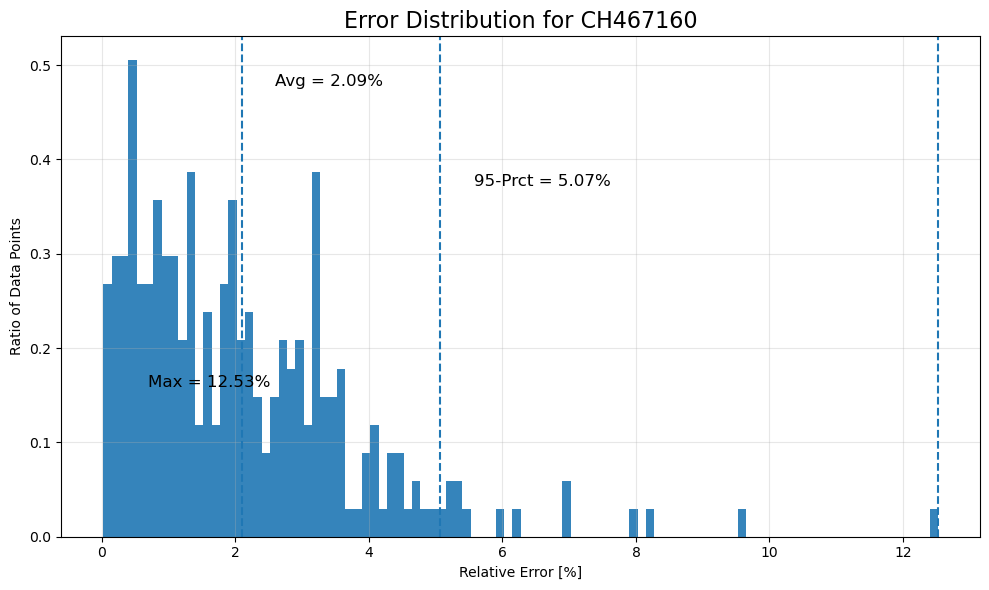

In [127]:
if __name__ == "__main__":
    main()